In [1]:
%matplotlib inline

import numpy as np
import scipy as sp
from scipy import stats

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pandas as pd
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_context("poster") 

import dateutil
import datetime

import lifelines
import statsmodels.iolib.foreign as smio
from rpy2.robjects import pandas2ri, r

import re

import pudb

In [2]:
#function to read file and put into array & dataframe
def read_data(filename,col1="Size",col2="Bed",col3="Price"):
    data_arr = np.loadtxt(filename,delimiter=",")
    data_df = pd.DataFrame(data_arr)
    data_df.index = list(range(1, data_df.shape[0]+1))
    data_df.columns = list([col1,col2,col3])
    return data_arr,data_df

In [3]:
data_arr,data_df = read_data('ex1data2.txt')

In [4]:
# function to plot scatterplot for preliminary data view
def plot_data(data_arr_x,data_arr_y,x_label,y_label,x_scale,y_scale,skip=1,color='black'):
    fig, ax = plt.subplots()
    ax.scatter(data_arr_x[0::skip]/x_scale, data_arr_y[0::skip]/y_scale,color=color)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    
    plt.xlim(min(data_arr_x/x_scale)-2,max(data_arr_x/x_scale)+2) 
    plt.ylim(min(data_arr_y/y_scale)-2,max(data_arr_y/y_scale)+2)
    
    find_grid_0 = np.where(ax.get_xticks() == 0)[0][0]
    find_grid_0 = find_grid_0.astype(int)
    
    x = ax.get_xgridlines()
    x_grid_0 = x[find_grid_0]
    x_grid_0.set_color('black')
    
    find_grid_0 = np.where(ax.get_yticks() == 0)[0][0]
    find_grid_0 = find_grid_0.astype(int)

    y = ax.get_ygridlines()
    y_grid_0 = y[find_grid_0]
    y_grid_0.set_color('black')
    

/Users/mobolajioo/anaconda/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


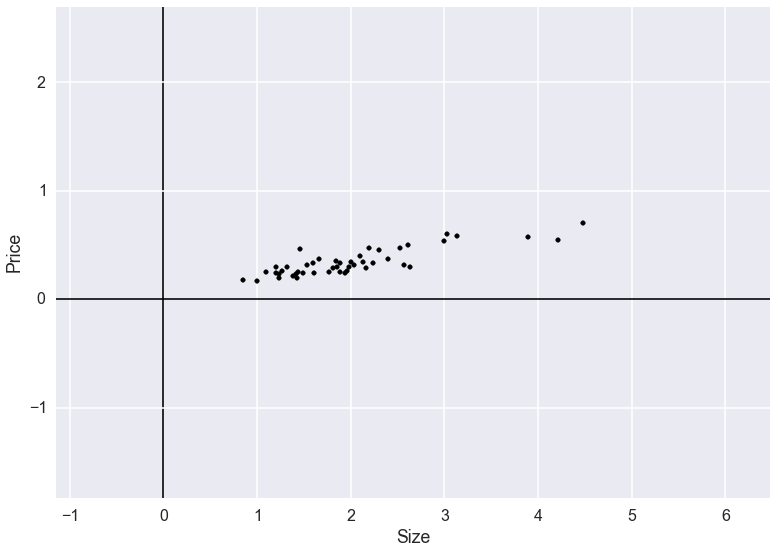

In [5]:
plot_data(data_arr[:,0],data_arr[:,2],"Size","Price",1000,1000000)

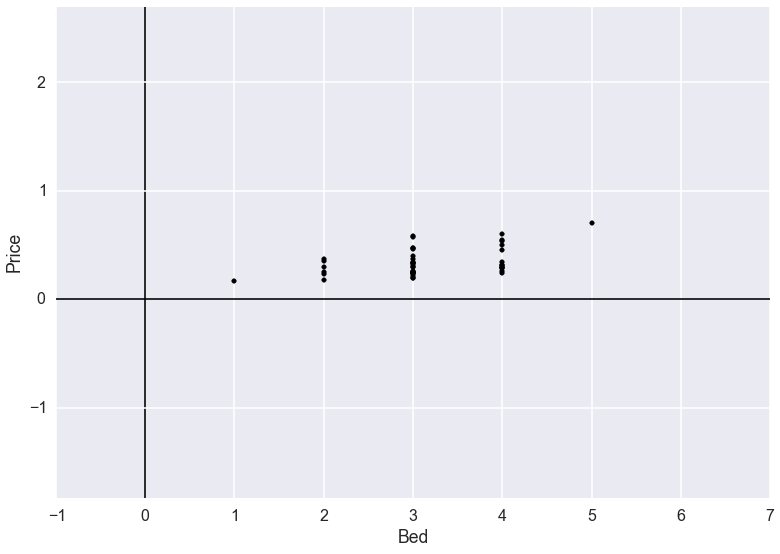

In [6]:
plot_data(data_arr[:,1],data_arr[:,2],"Bed","Price",1,1000000)

In [7]:
#get descriptive statistics into  a dataframe
desc_stats = pd.DataFrame(data_arr[:,:]).describe()
desc_stats = desc_stats.astype(int)
desc_stats.loc["median"] = pd.DataFrame(data_arr[:,:]).median()
desc_stats = desc_stats.reindex(["count", "mean", "median","std","min","25%","50%","75%","max"])
desc_stats

,0,1,2
count,47,47,47
mean,2000,3,340412
median,1888,3,299900
std,794,0,125039
min,852,1,169900
25%,1432,3,249900
50%,1888,3,299900
75%,2269,4,384450
max,4478,5,699900


In [8]:
#function that takes in data ndarray and returns arrays of examples(X), parameters(theta)
#and indicators(Y)
def make_X_theta_Y(data_arr,y_index):
    
    theta = np.zeros(shape=data_arr.shape[1])
    
    Y = data_arr[:,y_index]
    
    cols = data_arr.shape[1]
    cols = np.asarray(range(0,cols))
    
    X_Rest = data_arr[:,np.where(cols != y_index)]
    
    s1 = X_Rest.shape[0]
    s2 = X_Rest.shape[2]
    
    X_Rest = X_Rest.reshape((s1, s2))
    
    X_0 = np.ones(shape=s1)

    X = np.hstack((X_0[:, np.newaxis],X_Rest))
    
    return theta,X,Y


In [9]:
theta,X,Y = make_X_theta_Y(data_arr,2)

In [10]:
#function that takes in parameters(theta) and examples (X) and returns hypothesis (h)
def hypothesis(theta,X):
    h = np.dot(theta.T,X.T)
    return h

In [11]:
h = hypothesis(theta[:, np.newaxis],X)
h

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [12]:
#function that calculates the cost (J) from the hypothesis(h) and indicators(Y)
def error_cost(h,Y):
    
    a = h-Y
    b = a**2
    
    cost = b.sum()/(2*Y.shape[0])
    return cost

In [13]:
cost = error_cost(h,Y)
cost

65591548106.457443

In [14]:
#function that updates theta using batch gradient descent
def gradient_descent(theta,X,Y,alpha):
       
    h = hypothesis(theta,X)
    a = h-Y 
    
    g = np.zeros(theta.shape[0])
    
    for i in range(0,g.shape[0]):
        
        holder = a*X[:,i] 
        holder = holder.sum()
        holder = (holder*alpha)/(Y.shape[0])
        
        g[i] = holder

    new_theta = theta-g[:,np.newaxis]
    return new_theta

In [15]:
#set number of iterations of gradient descent to run and the value of alpha 
iterations = 1500
alpha = 0.00000001

In [16]:
#run gradient descent and save the changing values of the parameters(to_plot_0,to_plot_1)
#and cost (to_plot_j)

changing_theta = theta
theta_iter_i = changing_theta[:,np.newaxis]

changing_j = error_cost(hypothesis(theta_iter_i,X),Y)

for i in range(0,iterations):
    theta_iter_i = gradient_descent(theta_iter_i,X,Y,alpha) 

    changing_theta = np.hstack((changing_theta.reshape(3,i+1),theta_iter_i))
    
    s = error_cost(hypothesis(theta_iter_i,X),Y)
    changing_j = np.hstack((changing_j,s))


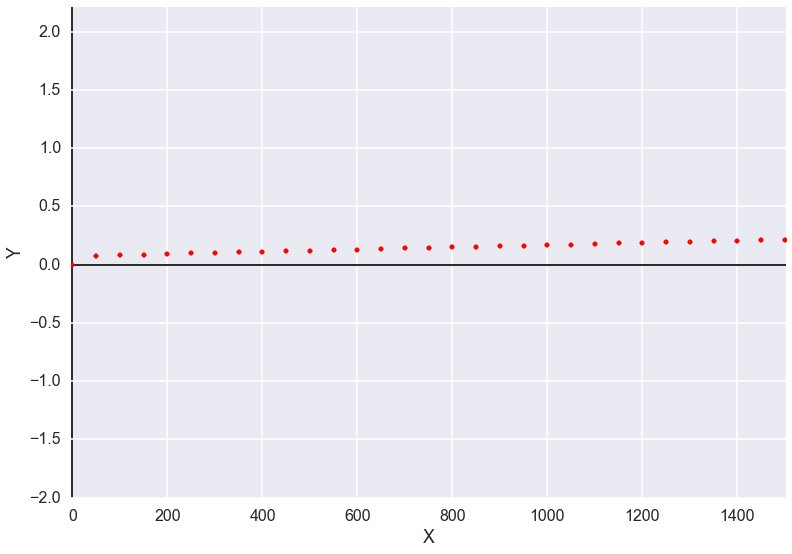

In [17]:
plot_data(np.asarray(range(0,changing_theta[0].shape[0])),changing_theta[0],"X","Y",1,1,50,'red')


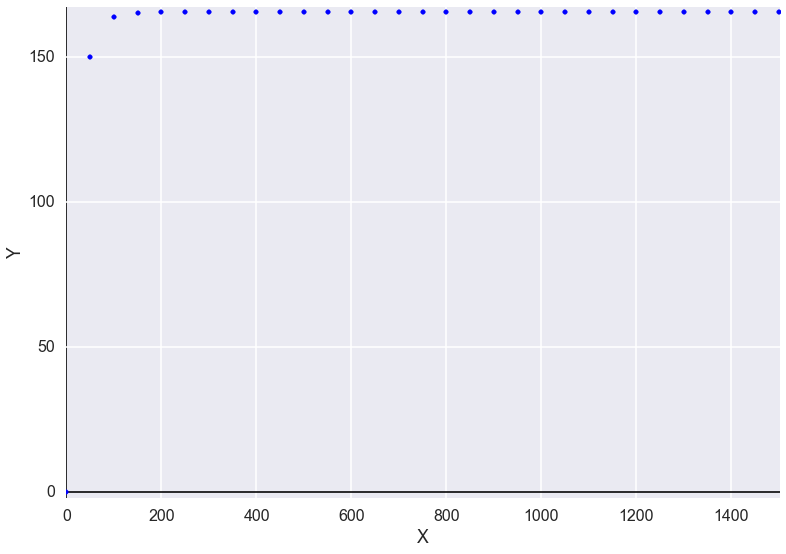

In [18]:
plot_data(np.asarray(range(0,changing_theta[1].shape[0])),changing_theta[1],"X","Y",1,1,50,'blue')


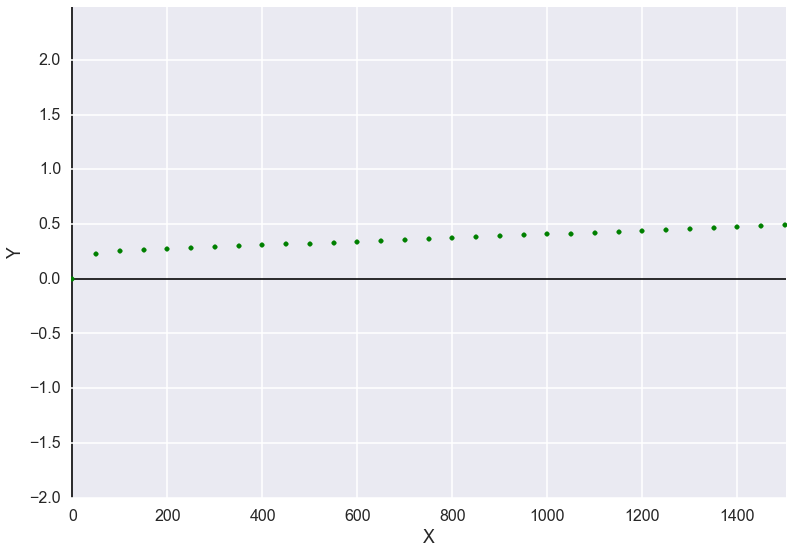

In [19]:
plot_data(np.asarray(range(0,changing_theta[2].shape[0])),changing_theta[2],"X","Y",1,1,50,'green')


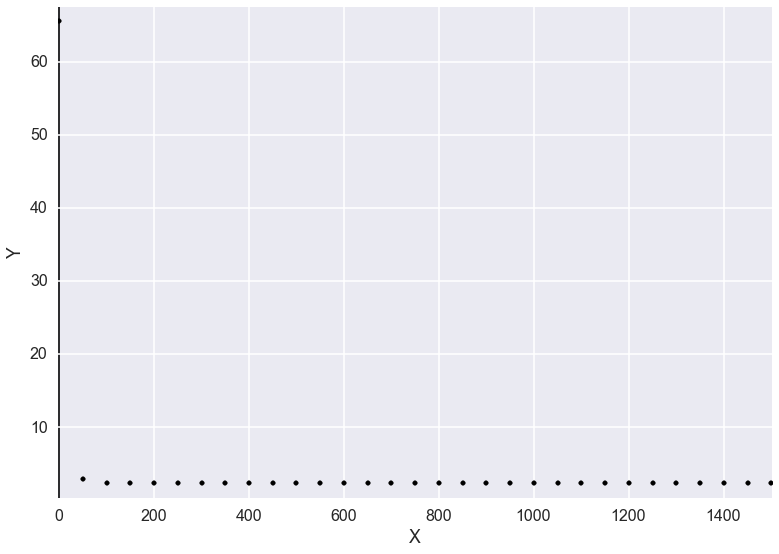

In [79]:
plot_data(np.asarray(range(0,changing_j.shape[0])),changing_j,"X","Y",1,10**9,50)


In [88]:
#plot_data(changing_theta[0],changing_j,"X","Y",10,1000000000,50)


In [54]:
#store values that parameters converged to into t0,t1,t2

t0 = changing_theta[0][-1]
t1 = changing_theta[1][-1]
t2 = changing_theta[2][-1]

In [53]:
#function to calculate y from optimized/converged t0,t1,t2
def fit_params(i,j,t0,t1,t2):
    y = t0+(t1*i)+(t2*j)
    return y

vec_fit_params = np.vectorize(fit_params)

In [50]:
#get range of values of size and bed to use to plot against predicted y on a surface

x_size = np.asarray([k for k in range(0,int(X[:,1].max()+1))])
x_bed = np.asarray([k for k in range(0,int(X[:,2].max()+1))])

In [55]:
#use range of values of size and bed to create meshgrid for surface plotting
mesh_x_size, mesh_x_bed = np.meshgrid(x_size,x_bed)

#use meshgrid of size and bed to get corresponding y values for surface plotting
mesh_y = vec_fit_params(mesh_x_size,mesh_x_bed,t0,t1,t2)


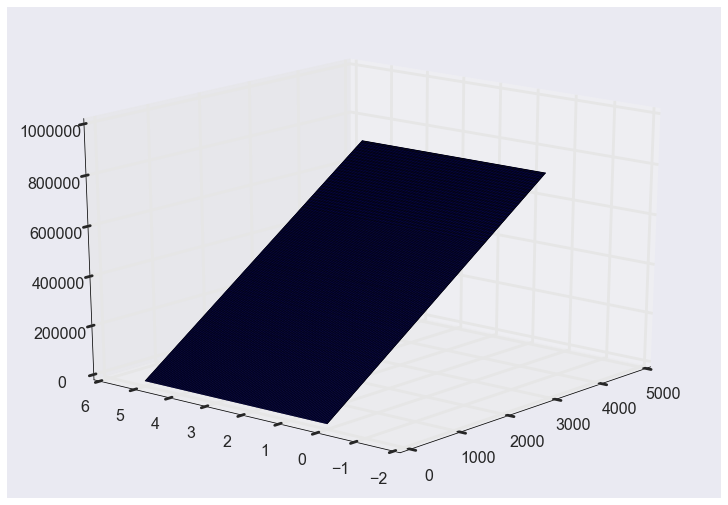

In [78]:
#plot predicted price as a function of different pair of values for size and bed


fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')

ax.plot_surface(mesh_x_size,mesh_x_bed,mesh_y,color='blue')

plt.xlim(-100,5000)
plt.ylim(-2,6)
ax.set_zlim(-1000,1000000)

ax.view_init(elev=20., azim=220)

#also plot line for price as a function of given pairs of size and bed
#ax.plot(data_arr[:,0],data_arr[:,1],data_arr[:,2],color='red')


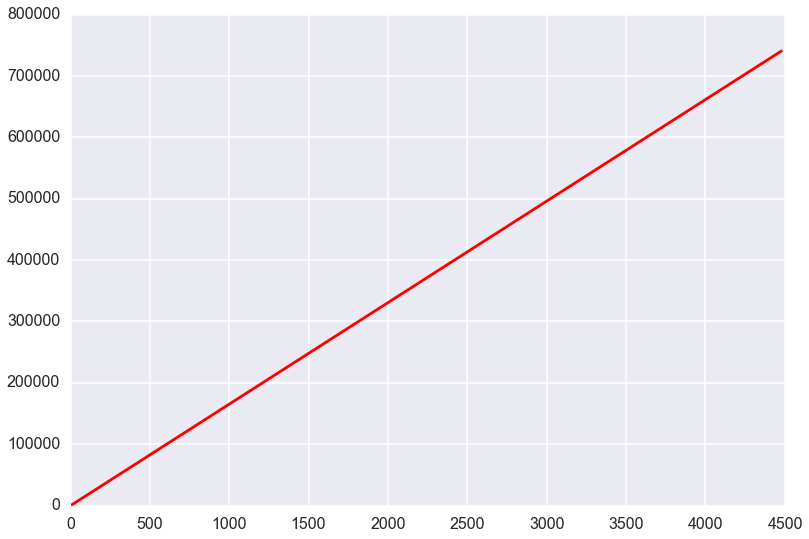

In [95]:
#plot the change in one paramter (size) as a function of y (price)
#when the other parameter (bed) is fixed (at 0)

sub_mesh_size = mesh_x_size[0]
sub_mesh_bed = mesh_x_bed[0]
sub_mesh_y = vec_fit_params(sub_mesh_size,sub_mesh_bed,t0,t1,t2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sub_mesh_size,sub_mesh_y,color='red')

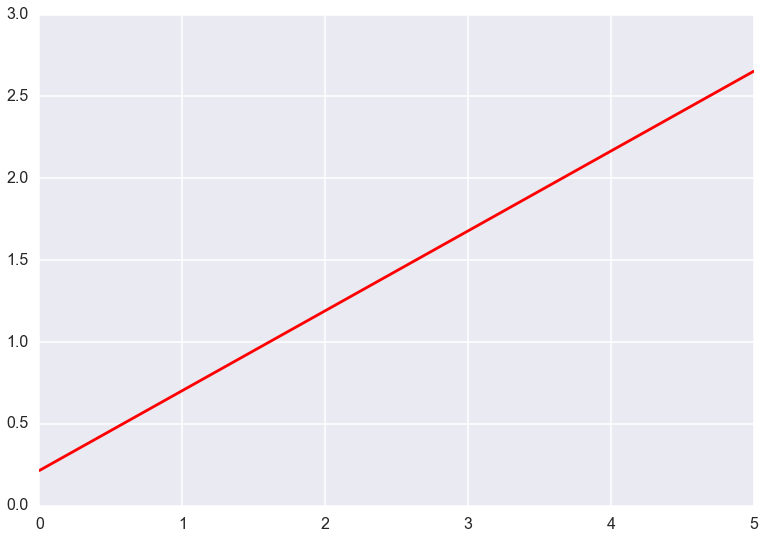

In [97]:
#plot the change in one paramter (bed) as a function of y (price)
#when the other parameter (size) is fixed (at 0)

sub_mesh_size = mesh_x_size[:,0]
sub_mesh_bed = mesh_x_bed[:,0]
sub_mesh_y = vec_fit_params(sub_mesh_size,sub_mesh_bed,t0,t1,t2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(sub_mesh_bed,sub_mesh_y,color='red')

array([0, 1, 2, 3, 4, 5])

In [ ]:
#make lists of x and y values to use for plotting surface fitted with parameters
#max_pop = int(data.ix[:,'Pop'].max().round())

#x_size = [k for k in range(0,X[:,1].max()+1)]
#x_bed = [k for k in range(0,X[:,2].max()+1)]

#y = [t0+(t1*i)+(t2*j) for i in x_size for j in x_bed]

In [21]:
#r = theta[:,np.newaxis]
#p = theta[np.newaxis,:][:]
#f = np.hstack((r,r))

#s = np.logical_not(np.isnan(changing_theta[1]))#.sum()
#r = changing_theta[1][s]
